In [1]:
from mersenne_twister import Mersenne
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter

<h1> Monte Carlo Voetbal simulatie </h1>
<h3> Levi Verhoef, V2A, 2021, 1785902 </h3>

In dit verslag ga ik op basis van een geleverde tabel van kansen een monte-carlo simulatie maken. Hieruit volgt een tabel met kansen voor elk team op een bepaalde plaatsing in het klassement.

Voor het genereren van willekeurige nummers heb ik zelf een Mersenne Twister geimplementeerd, die te vinden is in mersenne_twister.py en in dit project geimporteerd wordt als "Mersenne"

Eerst beginnen we met een nested dictionary aanmaken van de onderlinge winkansen, genaamd team_odds. De buitenste laag keys is het hometeam, de binnenste laag keys is het awayteam, met als value winkans/gelijkspelkans/verlieskans, gezien vanuit het hometeam.

In [2]:
team_odds = {'Ajax': {'Ajax': None, 'Feyenoord': '30/21/49', 'PSV': '39/22/39', 'FC Utrecht': '25/14/61',
                      'Willem II': '17/18/65'},
             'Feyenoord': {'Ajax': '65/17/18', 'Feyenoord': None, 'PSV': '54/22/24', 'FC Utrecht': '37/23/40',
                           'Willem II': '20/26/54'},
             'PSV': {'Ajax': '54/21/25', 'Feyenoord': '37/24/39', 'PSV': None, 'FC Utrecht': '29/24/47',
                     'Willem II': '23/24/53'},
             'FC Utrecht': {'Ajax': '74/14/12', 'Feyenoord': '51/22/27', 'PSV': '62/20/18', 'FC Utrecht': None,
                            'Willem II': '37/25/38'},
             'Willem II': {'Ajax': '78/13/9', 'Feyenoord': '60/21/19', 'PSV': '62/22/16', 'FC Utrecht': '52/23/25',
                           'Willem II': None}}

Nu is het tijd voor de simulatie zelf. De mersenne twister die ik geimplementeerd heb werkt op basis van seeds, en zullen we dus per simulatie een andere seed moeten geven. Ik kies er hier ervoor om simpelweg de iteratie waar we in zitten als seed te gebruiken. De eerste simulatie heeft dus seed 1, de tweede seed 2, enzovoort.

Er worden 20 wedstrijden gespeeld. Er zijn 5 teams die ieder thuis tegen 4 teams spelen, en uit tegen 4 teams spelen. We lopen door de thuisspelende teams heen, en door de teams tegen wie zij spelen. Per simulatie genereren we "resultaten", in de vorm van een lijst van getallen tussen de 1 en 101. Voor elke "match" pakken we de volgende waarde in de lijst van results, en vergelijken de gegeven kansen met het gegenereerde getal. 

Op basis van de puntenstanden genereren we vervolgens de eindstand, en als alle iteraties klaar zijn hebben we ons eindresultaat.

Deze functie is overigens zo geprogrammeerd dat als er 8 teams in de team_odds zouden zitten, hij nog steeds werkt. 

In [3]:
def simulate_matches(iterations, odds_dict):
    '''Does a monte carlo simulation of football matches, and saves the results in a dict of positions
       iterations param is the amount of iterations, odds_dict is a nested dict of team names and their respective match odds'''
    
    #initialize the posdict, where we save the results of each simulation
    posdict = {'Ajax': {'1st': 0, '2nd': 0, '3rd': 0, '4th': 0, '5th': 0},
           'Feyenoord': {'1st': 0, '2nd': 0, '3rd': 0, '4th': 0, '5th': 0},
           'PSV': {'1st': 0, '2nd': 0, '3rd': 0, '4th': 0, '5th': 0},
           'FC Utrecht': {'1st': 0, '2nd': 0, '3rd': 0, '4th': 0, '5th': 0},
           'Willem II': {'1st': 0, '2nd': 0, '3rd': 0, '4th': 0, '5th': 0}}
    
    #for each iteration of the simulation
    for i in range(1, iterations+1):
        rng = Mersenne(i) #generate rng based on current iteration count
        matchcount = len(posdict.keys()) * (len(posdict.keys())-1)
        results = iter([rng.randint(1, 101) for _ in range(matchcount+1)])  # generate random results based on how many teams this has
        scores = {team:0 for team in odds_dict.keys()} #generate scoredict for saving scores
        for awayteam, matchups in team_odds.items(): #loop outer layer
            for hometeam, odds in matchups.items(): #loop inner layer of odds
                if odds != None: #if the team plays itsself
                    oddslist = list(map(int, odds.split('/'))) #convert the odds for this match to list of ints
                    hometeamwin = oddslist[0] #extract the hometeam win chance
                    draw = oddslist[0] + oddslist[1] #extract draw chance, loss chance is the rest
                    result = next(results) #get the next result
                    if result <= hometeamwin: #if the result is hometeam win
                        scores[hometeam] += 3 #hometeam wins, 3 points
                    elif hometeamwin < result <= draw: #if result is a draw
                        scores[hometeam] += 1 #both teams score a point
                        scores[awayteam] += 1
                    else: #since we've checked 2 out of 3, rest is win awayteam
                        scores[awayteam] += 3 #away team wins

        sortedscores = sorted(scores, key=scores.get, reverse=True)[:5] #extract the placings
        for index, item in enumerate(sortedscores):
            posstr = ['1st', '2nd', '3rd', '4th', '5th'] #convert positions to strings
            posdict[item][posstr[index]] += 1 #add the final positions to posdict
    return posdict #result is a dictionary of counts at positions

Nu is het tijd om de simulatie daadwerkelijk uit te voeren. Ik heb hier gekozen voor 10000 simulaties. Dit duurt een kleine 30 seconden. 10000 samples geeft ons ruim voldoende data om een goed beeld te krijgen van hoe de competitie gemiddeld gezien zou verlopen. 

In [4]:
iters = 10000
simulation_result = simulate_matches(iters, team_odds)
simulation_result

{'Ajax': {'1st': 6164, '2nd': 2377, '3rd': 997, '4th': 370, '5th': 92},
 'Feyenoord': {'1st': 1143, '2nd': 2545, '3rd': 3191, '4th': 2171, '5th': 950},
 'PSV': {'1st': 2269, '2nd': 3586, '3rd': 2504, '4th': 1212, '5th': 429},
 'FC Utrecht': {'1st': 339,
  '2nd': 1082,
  '3rd': 2204,
  '4th': 3677,
  '5th': 2698},
 'Willem II': {'1st': 85, '2nd': 410, '3rd': 1104, '4th': 2570, '5th': 5831}}

Als resultaat krijgen we nu nog deze vrij lelijke dictionary. Als we die omzetten naar een pandas dataframe kunnen we de visualisatie van de data krijgen die we graag willen. We delen hier de occurences per positie door de hoeveelheid iteraties wat ons een percentage geeft.

In [ ]:
posdf = pd.DataFrame(simulation_result).transpose()
posdf = ((posdf/iters)*100)
posdf

tot slot maken we hier, voor de mooi, met seaborn nog even een mooie heatmap van, dit maakt de data nog makkelijker te lezen, <i>and looks pretty!</i>

In [ ]:
ax = sns.heatmap(posdf, cmap='Blues', linewidths = 0.5, annot=True, cbar=False, fmt='.2f')
for t in ax.texts: t.set_text(t.get_text() + "%")
ax.xaxis.set_ticks_position('top')

ax

We kunnen hier zien dat de kans dat Ajax op de 1e plek eindigt (62%), erg dichtbij de kans ligt dat Willem II laatste wordt (58%). De kans dat Feyenoord tweede wordt is even groot als de kans dat PSV 3e wordt (25%), en PSV is na Ajax de ploeg die de hoogste kans heeft om eerste te worden (23%).

In [5]:
We kunnen hier zien dat de kans dat Ajax op de 1e plek eindigt (62%), erg dichtbij de kans ligt dat Willem II laatste wordt (58%). De kans dat Feyenoord tweede wordt is even groot als de kans dat PSV 3e wordt (25%), en PSV is na Ajax de ploeg die de hoogste kans heeft om eerste te worden (23%).

,1st,2nd,3rd,4th,5th
Ajax,61.64,23.77,9.97,3.70,0.92
Feyenoord,11.43,25.45,31.91,21.71,9.50
PSV,22.69,35.86,25.04,12.12,4.29
FC Utrecht,3.39,10.82,22.04,36.77,26.98
Willem II,0.85,4.10,11.04,25.70,58.31


tot slot maken we hier, voor de mooi, met seaborn nog even een mooie heatmap van, dit maakt de data nog makkelijker te lezen, <i>and looks pretty!</i>

<AxesSubplot:>

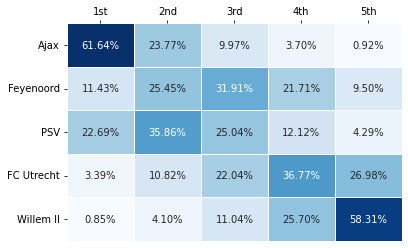

In [6]:
ax = sns.heatmap(posdf, cmap='Blues', linewidths = 0.5, annot=True, cbar=False, fmt='.2f')
for t in ax.texts: t.set_text(t.get_text() + "%")
ax.xaxis.set_ticks_position('top')

ax

We kunnen hier zien dat de kans dat Ajax op de 1e plek eindigt (62%), erg dichtbij de kans ligt dat Willem II laatste wordt (58%). De kans dat Feyenoord tweede wordt is even groot als de kans dat PSV 3e wordt (25%), en PSV is na Ajax de ploeg die de hoogste kans heeft om eerste te worden (23%).